In [1]:
import pygraphviz as pgv
from IPython.display import Image
import pandas as pd, numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

Having selected the variables to use in the BN after analysis in notebooks 03-04, in this notebook we:
- Just pick the variables of interest
- Write them to a nice csv
- Discretize the variables

To discretize, use two methods:

1) Regression tree analysis to determine break points

2) Simple terciles

In [76]:
# Read in data
fpath = r'../data/DataMatrices/VansjøData_%s_forBN.csv'

# Season list
season_li = ['summ','aut']

df_dict = {}
for season in season_li:
    infile = fpath %season
    df_dict[season] = pd.read_csv(infile, index_col = 0)

In [77]:
df_dict['summ'].head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,cyano_prevSummer,rain,rain_lag1,rainy_days_winter,temp,TP,TP_prevSummer,windDays_under_Q0.4,windDays_over_Q0.6
year,,,,,,,,,,,,,,
1980,12.169127,NaN,NaN,NaN,NaN,NaN,242.199218,80.992741,NaN,14.449403,36.084127,NaN,43.0,27.0
1981,7.075000,16.471230,NaN,NaN,NaN,NaN,282.257779,105.457323,102.0,13.213264,23.583333,43.573016,28.0,43.0
1982,5.466667,8.331250,NaN,NaN,NaN,NaN,151.006233,175.810938,105.0,13.452291,37.777778,28.833333,25.0,41.0
1983,5.980000,5.847917,19.4,26.666667,NaN,NaN,182.728817,122.882007,121.0,13.517998,31.960000,28.336806,23.0,51.0
1984,10.230000,6.073333,NaN,17.033333,NaN,NaN,255.820629,74.093285,121.0,13.845605,27.360000,29.055000,17.0,51.0


In [4]:
df_dict['aut'].head()

,chla,chla_lag1,chla_prevSummer,colour,colour_lag1,colour_prevSummer,cyano,cyano_lag1,cyano_prevSummer,rain,rain_lag1,rainy_days_winter,temp,TP,TP_lag1,TP_prevSummer,windDays_under_Q0.4,windDays_over_Q0.6
year,,,,,,,,,,,,,,,,,,
1980,20.773333,12.169127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351.676639,242.199218,NaN,9.575229,51.061905,36.084127,NaN,38.0,33.0
1981,9.587500,7.075000,16.471230,NaN,NaN,NaN,NaN,NaN,NaN,216.851554,282.257779,102.0,9.937926,34.083333,23.583333,43.573016,41.0,29.0
1982,6.229167,5.466667,8.331250,26.666667,NaN,NaN,NaN,NaN,NaN,297.668159,151.006233,105.0,10.870945,18.895833,37.777778,28.833333,28.0,47.0
1983,6.166667,5.980000,5.847917,14.666667,19.4,26.666667,NaN,NaN,NaN,275.606690,182.728817,121.0,10.877162,26.150000,31.960000,28.336806,25.0,51.0
1984,11.950000,10.230000,6.073333,NaN,NaN,17.033333,NaN,NaN,NaN,317.230629,255.820629,121.0,10.635043,25.695000,27.360000,29.055000,35.0,31.0


In [78]:
# Dictionary of explanatory variables linked to each response variable, for each season
xy_dict = {'summ':
              {'TP': ['TP_prevSummer'],
               'colour': ['colour_prevSummer','rain'],
               'chla': ['TP','chla_prevSummer', 'rainy_days_winter'],
               'cyano': ['chla','colour', 'cyano_prevSummer']},
           
           'aut':
              {'TP': ['TP_prevSummer'],
               'colour': ['colour_lag1','rain_lag1'],
               'chla': ['windDays_over_Q0.6','TP','chla_lag1'],
               'cyano': ['chla','colour','windDays_under_Q0.4', 'temp', 'cyano_lag1']}
          }  

In [6]:
# Regression tree, one for each dependent variable, including all possible explanatory variables in one tree
for season in season_li:
    for var in xy_dict[season].keys():
        temp_df = df_dict[season][[var]+xy_dict[season][var]].dropna()
        y = temp_df[var] # Target variable
        X = temp_df[xy_dict[season][var]] # Feature(s)
        regressor = DecisionTreeRegressor(random_state=0,
                                          max_depth=4,
                                          min_samples_split=6,
                                          min_samples_leaf=3,
                                          max_leaf_nodes=8
                                         )
        regressor.fit(X,y)

        # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
        dot_fpath = r'../Figures/Discretization_regTrees/AllVarsTogether/DotFiles/%s_%s.dot' %(season,var)
        export_graphviz(regressor, out_file =dot_fpath, 
                        feature_names = xy_dict[season][var])

        # Convert .dot file to .png
        png_fpath = r'../Figures/Discretization_regTrees/AllVarsTogether/%s_%s.png' %(season,var)
        pgv.AGraph(dot_fpath).draw(png_fpath, format='png', prog='dot')

In [18]:
# Regression tree, one for each pair of explanatory - dependent variable
for season in season_li:
    for targetvar in xy_dict[season].keys():
        for xvar in xy_dict[season][targetvar]:
            temp_df = df_dict[season][[targetvar]+[xvar]].dropna()
            y = temp_df[targetvar].values # Target variable data
            y = y.reshape(-1, 1)
            X = temp_df[xvar].values # Explanatory var data
            X = X.reshape(-1,1)
            regressor = DecisionTreeRegressor(random_state=0,
                                          max_depth=4,
                                          min_samples_split=6,
                                          min_samples_leaf=3,
                                          max_leaf_nodes=8
                                         )
            regressor.fit(X,y)

            # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
            dot_fpath = r'../Figures/Discretization_regTrees/Pairwise/DotFiles/%s_%s-%s.dot' %(season,targetvar,xvar)
            export_graphviz(regressor, out_file =dot_fpath, 
                            feature_names = [xvar])

            # Convert .dot file to .png
            png_fpath = r'../Figures/Discretization_regTrees/Pairwise/%s_%s-%s.png' %(season,targetvar,xvar)
            pgv.AGraph(dot_fpath).draw(png_fpath, format='png', prog='dot')

In [79]:
# Now want to merge the two seasons into one dataframe, with independently named variables

# rename_dict = {'summ':
#               'chla':'chla_ES',
#               'colour': 'colour_ES',
#               'cyano': 'cyano_ES',
#               'TP': 'TP_ES',
#               'rain': 'rain_ES'}

# Variables to drop that aren't used in the BN, by season
drop_vars_dict = {
                  'summ': ['rain_lag1', 'windDays_under_Q0.4', 'windDays_over_Q0.6', 'temp'],
                  'aut': ['TP_lag1', 'rain', 'chla_prevSummer',  'colour_prevSummer', 'cyano_prevSummer', 'rainy_days_winter']
                 }

# For variables in this list, add suffix _ES or _LS for early and late summer
suffix_li = ['chla','colour','cyano','TP','rain'] #  N.B. includes more variables for late summer, added in loop below
suffix_dict = {'summ':'_ES', 'aut':'_LS'}

df_li = []
# Start renaming and dropping
for season in season_li:
    df = df_dict[season]
    for col in df.columns:
        if col in drop_vars_dict[season]:
            df.drop(col, axis=1, inplace=True)
        
        if season == 'aut':
            suffix_li += ['temp','windDays_under_Q0.4', 'windDays_over_Q0.6']
        if col in suffix_li and col not in drop_vars_dict[season]:
            df[col+'%s' %suffix_dict[season]] = df[col]
            df.drop(col, axis=1, inplace=True)

        # Replace anything ending with '_lag1' with '_ES'
        # There should only be _lag1 vars for late summer
        if season == 'aut':
            if col[-5:] == '_lag1' and col not in drop_vars_dict[season]:
                df[col[:-5]+'_ES'] = df[col]
                df.drop(col, axis=1, inplace=True)
    df_li.append(df)

# Join the early and late summer dataframes into one and drop duplicated columns (e.g. early summer TP, chla, etc. are in both dfs)
cont_df = pd.concat(df_li, axis=1)
cont_df = cont_df.loc[:,~cont_df.columns.duplicated()]

sorted(cont_df.columns)

['TP_ES',
 'TP_LS',
 'TP_prevSummer',
 'chla_ES',
 'chla_LS',
 'chla_prevSummer',
 'colour_ES',
 'colour_LS',
 'colour_prevSummer',
 'cyano_ES',
 'cyano_LS',
 'cyano_prevSummer',
 'rain_ES',
 'rainy_days_winter',
 'temp_LS',
 'windDays_over_Q0.6_LS',
 'windDays_under_Q0.4_LS']

In [80]:
# For colour, don't have WFD class boundaries that we're interested in. Instead, just define using terciles for starters
all_colour_data = pd.concat([cont_df['colour_ES'], cont_df['colour_LS']])

for q in [0.33, 0.66]:
    print('Q: %s' %all_colour_data.quantile(q))

Q: 27.94222222222222
Q: 49.59076923076923


### Save the new continuous dataframe

In [21]:
cont_df.to_csv(r'../data/DataMatrices/Vansjo_Seasonal_Continuous.csv')

## Preliminary class boundaries

Pick class boundaries from examination of regression trees and scatter plots, and for each variable plot where they lie to see how many data points we will have in each class (not considering joint classes for now)

Notes for particular variables:
TP: WFD class boundaries are 20.0 and 39.0 ug/l. However, pretty much all data are within the 'moderate' class between these two bounds, leading to no data issues when we try to link TP to other nodes. So reduce to just two categories, above or below the midpoint of the 'Moderate' ecological status class.

In [81]:
bound_dict = {
             'TP_ES': [29.5], # No data below 20, so drop this class boundary
             'TP_LS': [29.5],
             'TP_prevSummer': [26.4, 31.5],
             'chla_ES': [10.5, 20.0],
             'chla_LS': [10.5, 20.0],
             'chla_prevSummer': [16.8],
             'colour_ES': [27.9, 49.6],
             'colour_LS': [27.9, 49.6],
             'colour_prevSummer': [26.9, 36.5, 60.4],
             'cyano_ES': [1.0, 2.0],
             'cyano_LS': [1.0, 2.0],
             'cyano_prevSummer': [0.531],
             'rain_ES': [220],
             'rainy_days_winter': [144],
             'temp_LS': [10.9],
             'windDays_over_Q0.6_LS': [33.5],
             'windDays_under_Q0.4_LS': [43.5]
            }

# Previous boundaries used:
#              'TP_ES': [29.5, 39.0], # No data below 20, so drop this class boundary
#              'TP_LS': [20.0, 29.5, 39.0],

Also define boundaries using terciles

In [82]:
bound_dict_terciles = {}

for var in cont_df.columns:
    bound_dict_terciles[var] = [cont_df[var].quantile(0.333), cont_df[var].quantile(0.667)]

bound_dict_terciles

{'chla_prevSummer': [12.677744444444441, 17.274897435897437],
 'colour_prevSummer': [27.352777777777774, 50.70753846153846],
 'cyano_prevSummer': [0.21844653384264293, 1.2872465850733334],
 'rainy_days_winter': [135.642, 147.679],
 'TP_prevSummer': [28.10704513888889, 31.826485576923076],
 'chla_ES': [11.641133333333334, 16.454000000000004],
 'colour_ES': [29.275416666666665, 53.06416666666668],
 'cyano_ES': [0.12334750543585717, 0.7302280000000002],
 'rain_ES': [185.20286890968202, 245.367587975326],
 'TP_ES': [27.517200000000003, 31.549533333333333],
 'chla_LS': [13.00614666666667, 18.68866666666667],
 'colour_LS': [26.552000000000003, 48.54998974358974],
 'cyano_LS': [0.2635223647780001, 1.1876963489933339],
 'temp_LS': [10.121287410531806, 11.064023806591129],
 'TP_LS': [26.618625, 31.612083333333334],
 'windDays_under_Q0.4_LS': [36.0, 41.0],
 'windDays_over_Q0.6_LS': [31.321, 35.0]}

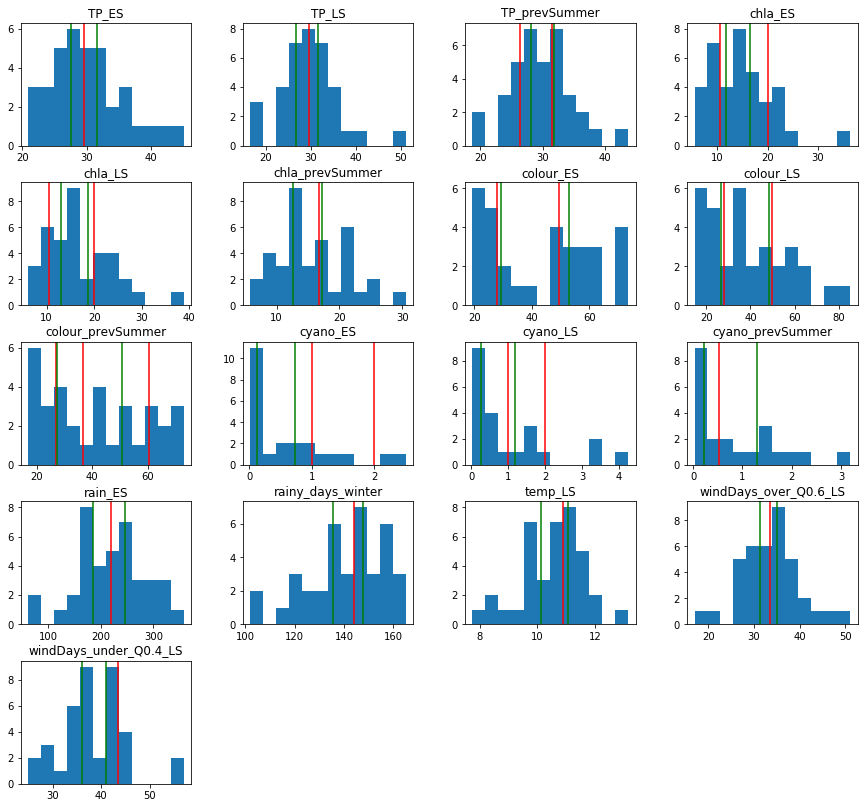

In [83]:
axes = cont_df.hist(bins=12, figsize=(15,14), grid=False)

# For each subplot, add on vetical lines for the proposed class boundaries
# N.B. assumes order of plots is the same as the order of keys in bound_dict
var_li = sorted(list(bound_dict.keys()))

for i, ax in enumerate(axes.flatten()):
    if i<17:
        lines = bound_dict[var_li[i]]
        for line in lines:
            ax.axvline(x=line, color='r')
        tercile_lines = bound_dict_terciles[var_li[i]]
        for tercLine in tercile_lines:
            ax.axvline(x=tercLine, color='g')

plt.show()

## Produce discretized dataframe using manually chosen boundaries

In [84]:
def discretize(thresholds, value):
    
    if np.isnan(value):
        return np.NaN
    
    factor_li_dict = {2: ['L','H'],
                     3: ['L','M','H'],
                     4: ['VL','L','M','H'],
                     5: ['VL','L','M','H','VH']}
    
    n_classes = len(thresholds)+1
    
    for i, boundary in enumerate(thresholds):
    
        if value<boundary:
            return factor_li_dict[n_classes][i]
            break # Break out of loop
        
        # If we're up to the last class boundary, and the value is bigger than it, value is in the uppermost class
        if i+1 == len(thresholds) and value >= boundary:
            return factor_li_dict[n_classes][i+1]


In [85]:
# Create empty dataframe to be populated with discretized data
disc_df = pd.DataFrame(index=cont_df.index, columns=cont_df.columns)

for var in cont_df.columns:
    disc_df[var] = cont_df[var].apply(lambda x: discretize(bound_dict[var], x))
    
disc_df.head(10)

,chla_prevSummer,colour_prevSummer,cyano_prevSummer,rainy_days_winter,TP_prevSummer,chla_ES,colour_ES,cyano_ES,rain_ES,TP_ES,chla_LS,colour_LS,cyano_LS,temp_LS,TP_LS,windDays_under_Q0.4_LS,windDays_over_Q0.6_LS
year,,,,,,,,,,,,,,,,,
1980,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,H,H,H,NaN,NaN,L,H,L,L
1981,L,NaN,NaN,L,H,L,NaN,NaN,H,L,L,NaN,NaN,L,H,L,L
1982,L,NaN,NaN,L,M,L,NaN,NaN,L,H,L,L,NaN,L,L,L,H
1983,L,VL,NaN,L,M,L,L,NaN,L,H,L,L,NaN,L,L,L,H
1984,L,VL,NaN,L,M,L,NaN,NaN,H,L,M,NaN,NaN,L,L,L,L
1985,L,NaN,NaN,L,M,L,M,NaN,H,H,M,M,NaN,L,L,L,H
1986,L,L,NaN,L,H,M,M,NaN,L,H,M,L,NaN,L,H,L,H
1987,L,L,NaN,L,H,L,L,NaN,H,L,M,M,NaN,L,L,L,H
1988,L,L,NaN,H,L,M,L,NaN,H,H,M,M,NaN,L,L,L,H


In [102]:
ax.shape

(4, 5)

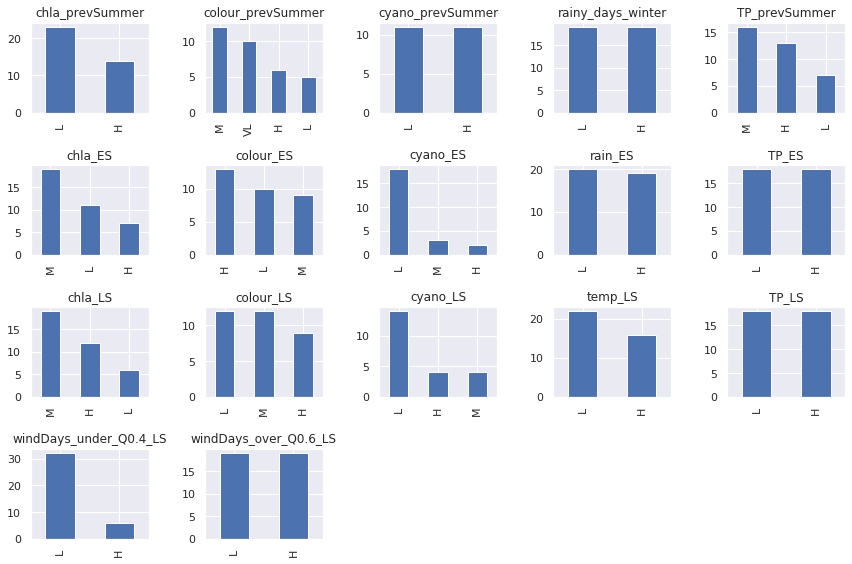

In [109]:
# How balanced are the classes?

fig, ax = plt.subplots(4,5, figsize=(12,8))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-3:]:
    fig.delaxes(axi)
plt.tight_layout()

## Discretize using terciles

In [14]:
# Create empty dataframe to be populated with discretized data using terciles
disc_df_terc = pd.DataFrame(index=cont_df.index, columns=cont_df.columns)

for var in cont_df.columns:
    disc_df_terc[var] = cont_df[var].apply(lambda x: discretize(bound_dict_terciles[var], x))
    
disc_df_terc.tail(10)

,chla_prevSummer,colour_prevSummer,cyano_prevSummer,rainy_days_winter,TP_prevSummer,chla_ES,colour_ES,cyano_ES,rain_ES,TP_ES,chla_LS,colour_LS,cyano_LS,temp_LS,TP_LS,windDays_under_Q0.4_LS,windDays_over_Q0.6_LS
year,,,,,,,,,,,,,,,,,
2009,M,H,M,M,H,M,H,M,M,M,M,H,M,M,M,H,L
2010,M,H,M,H,M,M,H,L,M,M,L,H,L,M,L,H,M
2011,L,H,L,L,L,M,H,L,H,L,L,H,L,H,L,M,H
2012,L,H,L,M,L,M,H,L,H,M,L,H,L,M,L,L,H
2013,M,H,L,L,L,M,H,M,H,L,M,M,M,H,L,H,L
2014,M,H,M,M,L,M,M,L,L,L,L,M,L,H,L,H,L
2015,L,M,L,M,L,M,M,L,H,L,M,H,L,H,L,M,H
2016,M,H,L,H,L,L,M,L,L,L,L,H,L,H,L,L,H
2017,L,H,L,L,L,M,NaN,L,M,NaN,L,NaN,L,M,NaN,L,H


## Save both discretized dataframes and boundaries used

In [87]:
disc_df.to_csv(r'../data/DataMatrices/Vansjo_Seasonal_Discretized_RegTree.csv')
disc_df_terc.to_csv(r'../data/DataMatrices/Vansjo_Seasonal_Discretized_Terciles.csv')

## Quick look at NaNs per class, and how balanced classes are

In [88]:
disc_df.isna().sum()

chla_prevSummer            2
colour_prevSummer          6
cyano_prevSummer          17
rainy_days_winter          1
TP_prevSummer              3
chla_ES                    2
colour_ES                  7
cyano_ES                  16
rain_ES                    0
TP_ES                      3
chla_LS                    2
colour_LS                  6
cyano_LS                  17
temp_LS                    1
TP_LS                      3
windDays_under_Q0.4_LS     1
windDays_over_Q0.6_LS      1
dtype: int64

## Transforming continuous data to make it more Gaussian

It could be good for the BN to be continuous rather than discrete, but BNLearn assumes all nodes are Gaussian. From a look at the histograms above most aren't far off bell-shaped, aside from colour and cyanobacteria. We could just drop all the colour variables from this BN and put it into its own BN. For cyanobacteria, the distribution is right-skewed and has lots of zeros. In reality these won't really be zeros, just below the counting detection limit. So some kind of transformation is required which can cope with zeros.

First, try square rooting.

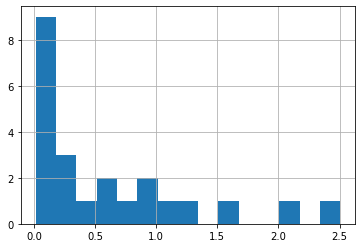

In [21]:
# Original data
cont_df['cyano_ES'].hist(bins=15)

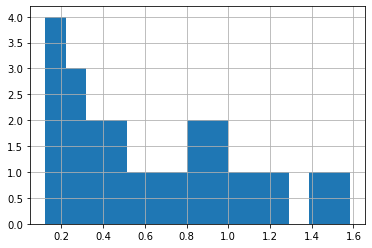

In [23]:
np.sqrt(cont_df['cyano_ES']).hist(bins=15)

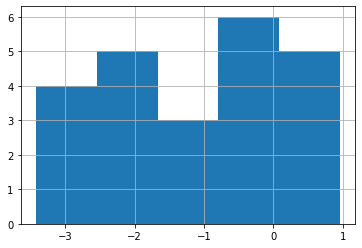

In [75]:
# Try box cox, y* = (y^l - 1)/L, where L != 0. L close to 0 is a near-logorithmic transformation

from scipy.stats import boxcox
bs = boxcox(cont_df['cyano_ES'].values, lmbda=0.1)

trans_df = pd.DataFrame(index = cont_df.index)
trans_df['original'] = cont_df['cyano_ES']
trans_df['boxcox'] = bs

trans_df['boxcox'].hist(bins=5)

lambda (L) between 0.06 and 0.2 produces symmetrical data. Doesn't look  bell shaped (in fact looks bimodal), but that could easily be because of the low n. No reason to pick any particular number between 0.06 and 0.2, so decide to go with 0.1 as a nice even number.

Will then need to back-transform the predictions later: y = (x*lambda + 1)^(1/lambda)